In [2]:
#logistic regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load the data
data = pd.read_csv('pseudodata_præoperation.csv')

#make pd to np
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

# Generate a synthetic dataset
X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

class_weights = torch.tensor([1/0.98, 1/0.02])

# Define the logistic regression model with L2 regularization
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

input_dim = 575

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy, model

# Outer 10-Fold Cross-Validation
outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []
best_model_params = None
best_outer_accuracy = 0

y_remaining = y_tensor[remaining_indices]

for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
    outer_train_subset = Subset(remaining_set, outer_train_index)
    outer_test_subset = Subset(remaining_set, outer_test_index)
    
    # Inner 10-Fold Cross-Validation
    inner_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_accuracies = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
        inner_train_indices = np.array(outer_train_index)[inner_train_index]
        inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
        inner_train_subset = Subset(remaining_set, inner_train_indices)
        inner_val_subset = Subset(remaining_set, inner_val_indices)
        
        train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
        accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=1e-5)
        inner_accuracies.append(accuracy)
        print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

    mean_inner_accuracy = np.mean(inner_accuracies)
    print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

    train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
    outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=1e-5)
    outer_accuracies.append(outer_accuracy)
    print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

    if outer_accuracy > best_outer_accuracy:
        best_outer_accuracy = outer_accuracy
        best_model_params = outer_model.state_dict()

print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
print('Best model parameters:', best_model_params)

# Evaluate the final model on the holdout set
final_model = LogisticRegressionModel(input_dim)
final_model.load_state_dict(best_model_params)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# Evaluate on holdout set
final_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in holdout_loader:
        outputs = final_model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

holdout_accuracy = correct / total
print(f'Holdout Set Accuracy: {holdout_accuracy * 100:.2f}%')




Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 50.83%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 49.17%
Inner Fold Accuracy: 48.35%
Inner Fold Accuracy: 52.48%
Inner Fold Accuracy: 49.79%
Inner Fold Accuracy: 48.13%
Inner Fold Accuracy: 54.36%
Inner Fold Accuracy: 50.62%
Outer Fold Mean Inner Accuracy: 50.13%
Outer Fold Accuracy: 47.21%
Inner Fold Accuracy: 46.69%
Inner Fold Accuracy: 50.41%
Inner Fold Accuracy: 45.45%
Inner Fold Accuracy: 48.35%
Inner Fold Accuracy: 45.87%
Inner Fold Accuracy: 55.37%
Inner Fold Accuracy: 55.19%
Inner Fold Accuracy: 49.38%
Inner Fold Accuracy: 52.28%
Inner Fold Accuracy: 50.21%
Outer Fold Mean Inner Accuracy: 49.92%
Outer Fold Accuracy: 50.56%
Inner Fold Accuracy: 54.55%
Inner Fold Accuracy: 52.48%
Inner Fold Accuracy: 51.65%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 45.87%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 47.72%
Inner Fold Accuracy: 52.28%
Inner Fold Accuracy: 48.96%
Inner Fold Accuracy: 50.21%
Outer Fold Mean Inner Accu

Recall Score: 0.5377777777777778


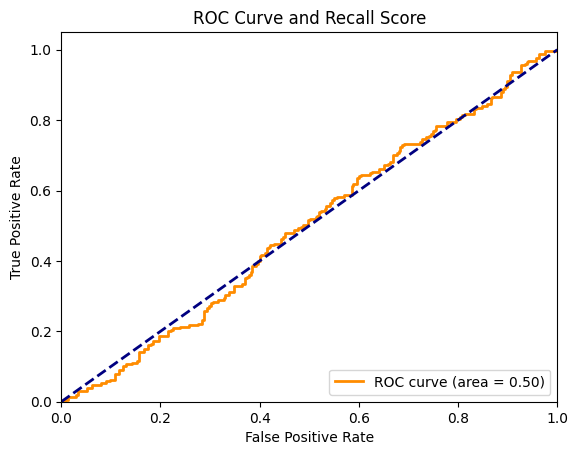

LogisticRegressionModel(
  (linear): Linear(in_features=575, out_features=1, bias=True)
)

In [4]:
from sklearn.metrics import roc_curve, auc, recall_score
import matplotlib.pyplot as plt

# Function to calculate AUC-ROC curve and recall score
def plot_roc_curve_and_recall(model, loader, title="ROC Curve and Recall Score"):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            y_true.extend(labels.numpy())
            y_scores.extend(outputs.numpy())

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Calculate Recall Score
    y_pred = (np.array(y_scores) > 0.5).astype(int)
    recall = recall_score(y_true, y_pred)
    print("Recall Score:", recall)

# Define DataLoader for holdout set
holdout_loader = DataLoader(holdout_set, batch_size=len(holdout_set), shuffle=False)

# Load best model parameters
final_model = LogisticRegressionModel(input_dim)
final_model.load_state_dict(best_model_params)

# Plot ROC curve and calculate recall score
plot_roc_curve_and_recall(final_model, holdout_loader)
plt.show()



In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('pseudodata_præoperation.csv')

# Convert to numpy array and generate synthetic labels for demonstration
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

# Standardize the data
X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set

train_indices, holdout_indices = train_test_split(np.arange(len(dataset)), test_size=500, random_state=42, stratify=y_tensor.numpy())

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, train_indices)

# Define class weights for BCEWithLogitsLoss
class_weights = torch.tensor([1/0.98, 1/0.02])

# Define the logistic regression model with L2 regularization
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

input_dim = 575

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float().squeeze()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, model

weight_decays = [1e-4, 1e-5, 1e-6]
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Function to perform grid search over weight_decay values
def grid_search(train_set, outer_kf, weight_decays, input_dim, num_epochs=10, lr=0.01):
    best_weight_decay = None
    best_outer_accuracy = 0
    y_remaining = y_tensor[train_indices].numpy()

    for weight_decay in weight_decays:
        outer_accuracies = []
        
        for outer_train_index, outer_test_index in outer_kf.split(np.zeros(len(train_set)), y_remaining):
            
            outer_train_subset = Subset(train_set, outer_train_index)
            outer_test_subset = Subset(train_set, outer_test_index)
            
            # Inner 10-Fold Cross-Validation
            inner_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            inner_accuracies = []
            
            for inner_train_index, inner_val_index in inner_kf.split(np.zeros(len(outer_train_index)), y_remaining[outer_train_index]):
                
                inner_train_indices = np.array(outer_train_index)[inner_train_index]
                inner_val_indices = np.array(outer_train_index)[inner_val_index]
                
                inner_train_subset = Subset(train_set, inner_train_indices)
                inner_val_subset = Subset(train_set, inner_val_indices)
                
                train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
                val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
                
                accuracy, _ = train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs, lr, weight_decay)
                inner_accuracies.append(accuracy)
            
            mean_inner_accuracy = np.mean(inner_accuracies)
            
            # Train on outer train subset and evaluate on outer test subset
            train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
            test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
            
            outer_accuracy, _ = train_and_evaluate_model(train_loader, test_loader, input_dim, num_epochs, lr, weight_decay=weight_decay)
            outer_accuracies.append(outer_accuracy)
        
        mean_outer_accuracy = np.mean(outer_accuracies)
        print(f'Weight Decay: {weight_decay}, Mean Outer Accuracy: {mean_outer_accuracy * 100:.2f}%')
        
        if mean_outer_accuracy > best_outer_accuracy:
            best_outer_accuracy = mean_outer_accuracy
            best_weight_decay = weight_decay
    
    return best_weight_decay

# Perform grid search over weight_decay values

best_weight_decay = grid_search(remaining_set, outer_kf, weight_decays, input_dim, num_epochs=10, lr=0.01)

print(f'Best Weight Decay: {best_weight_decay}')

# Evaluate the final model on the holdout set
final_model = LogisticRegressionModel(input_dim)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# Train the final model with the best weight decay found
holdout_accuracy, _ = train_and_evaluate_model(train_loader, holdout_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=best_weight_decay)
print(f'Final Model Accuracy on Holdout Set: {holdout_accuracy * 100:.2f}%')

# Evaluate precision and recall on holdout set
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in holdout_loader:
        outputs = final_model(inputs)
        predicted = (outputs > 0.5).float()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

holdout_precision = precision_score(all_labels, all_preds)
holdout_recall = recall_score(all_labels, all_preds)

print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%')
print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')


Weight Decay: 0.0001, Mean Outer Accuracy: 49.53%
Weight Decay: 1e-05, Mean Outer Accuracy: 49.50%
Weight Decay: 1e-06, Mean Outer Accuracy: 49.65%
Best Weight Decay: 1e-06
Final Model Accuracy on Holdout Set: 50.00%
Holdout Set Precision: 46.22%
Holdout Set Recall: 44.00%
